# Krypton Corrections

## Correction of a run, using previously computed energy map

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Aug 24 21:31:48 2018


### Input files

In [2]:
input_file_names  = ['dst_6284_trigger1_0000_7920.h5','dst_6285_trigger1_0000_7774.h5',
                    'dst_6286_trigger1_0000_7901.h5','dst_6287_trigger1_0000_7918.h5',
                    'dst_6288_trigger1_0000_7913.h5','dst_6289_trigger1_0000_8004.h5',
                    'dst_6290_trigger1_0000_4582.h5','dst_6291_trigger1_0000_4582.h5']



In [2]:
from krcal.core.kr_types import KrFileName

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6285_trigger1_0000_7774.h5']
                    

output_file_name  = ' '
map_file_name     = 'kr_maps_6284_6291.h5'       # LT maps (average)
map_file_name_ts  = 'kr_maps_ts_6284_6291.h5'    # LT maps (time series)
emap_file_name    = 'kr_emap_6284_6288.h5'       # energy map

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [6]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map

In [7]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [8]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [9]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [10]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import energy_map
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [11]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [12]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [13]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map2
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_energy_map
from krcal.core.map_functions   import draw_energy_map_df


In [14]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [15]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import lt_correction

In [16]:
import krcal.dev.corrections       as corrections 


In [17]:
from numpy import pi

In [18]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [19]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [20]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6285_trigger1_0000_7774.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6284_6291.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6284_6291.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6284_6288.h5')

In [21]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [22]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 1558648


In [23]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Select in R

In [24]:
RMAX       =180
NSECTORS   =10   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =15  # size of the wedge in degrees
NW = 360 / SPHI

fr = RMAX / NSECTORS
fphi = SPHI
print(f'fr = {fr}, fphi = {fphi}')


fr = 18.0, fphi = 15


In [25]:
dstf = dst[dst.R<RMAX]

In [26]:
dst = dstf

### Time differences in seconds

In [27]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [28]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Raw S2 energy vs Z

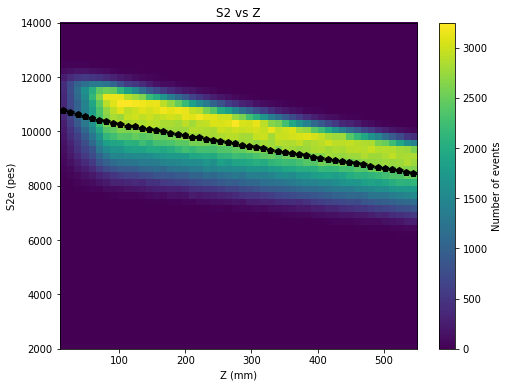

In [29]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

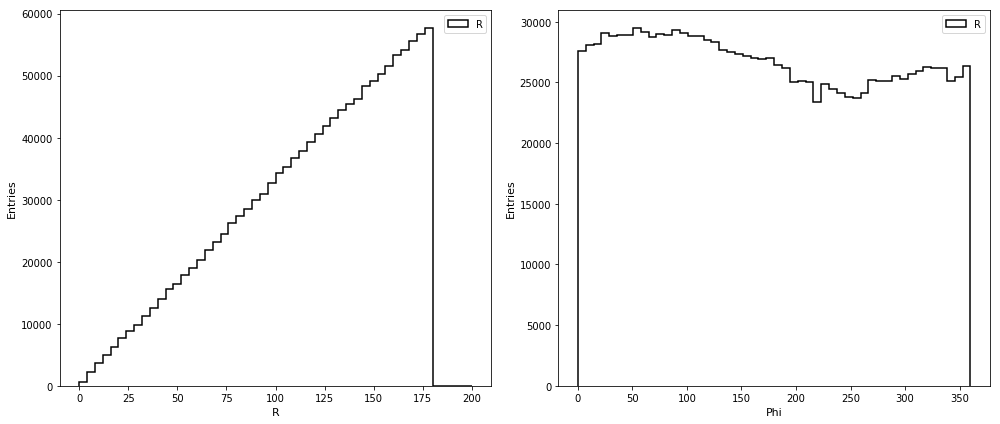

In [30]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(dst.R, bins=50, range = (0,200), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(phirad_to_deg(dst.Phi), bins=50, range = (0,360), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Plot "quantified" R and Phi

In [31]:
R = (dst.R.values / fr).astype(int)
Phi = (phirad_to_deg(dst.Phi.values) / fphi).astype(int)

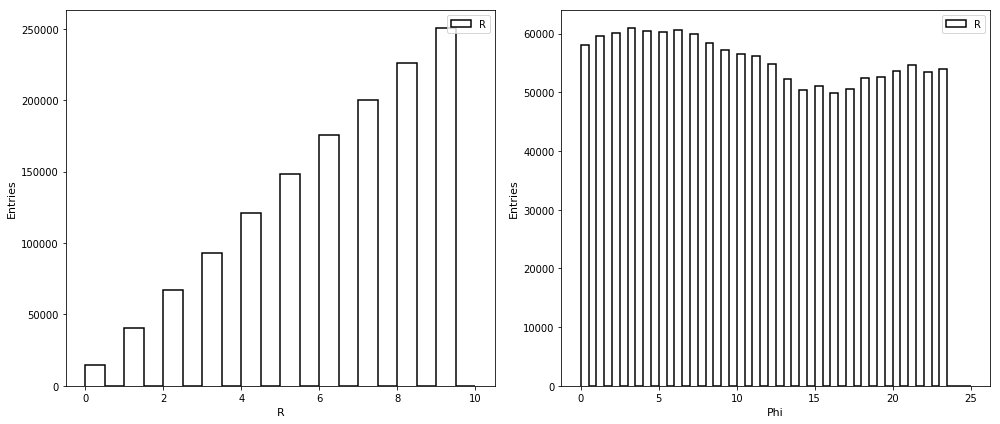

In [32]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(R, bins=20, range = (0,10), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(Phi, bins=50, range = (0,25), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Load maps

In [33]:
me0df, me0udf, mltdf, mltudf = read_maps(fn.map_file_name)
mu = (me0df.mean()).mean()
mx = (me0df.max()).max()

### E0 (geometry) correction

In [34]:
t0 = time.time()
E0 = e0_correction(dst.S2e.values, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = me0df / mx,  # normalize to max E0
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 11.256845951080322


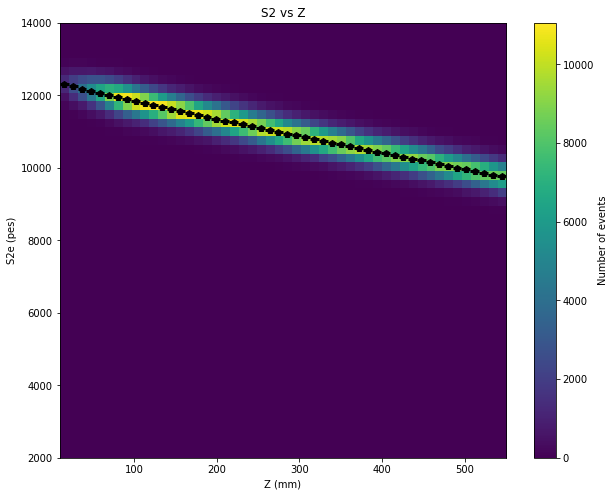

In [35]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [36]:
t0 = time.time()
E = lt_correction(E0, 
                  dst.R.values, 
                  dst.Phi.values,
                  dst.Z.values, 
                  CLT = mltdf,
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 11.086691856384277


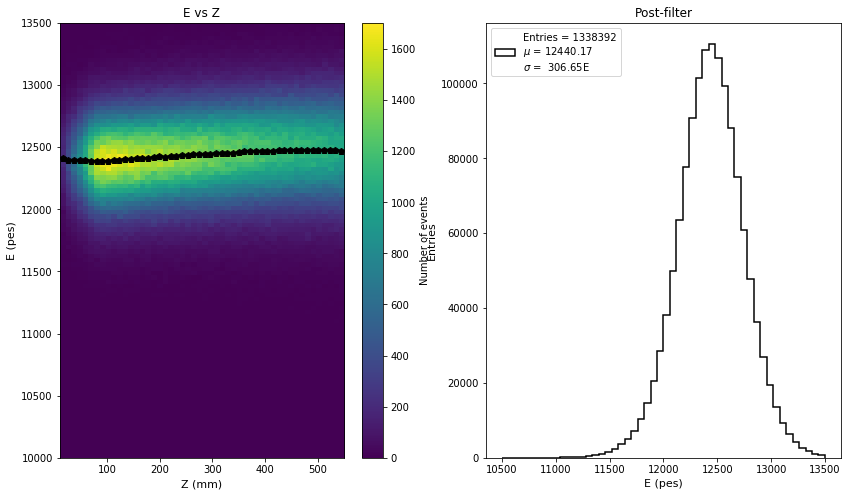

In [37]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, 100, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

In [38]:
fc = fit_energy(E, nbins=50, range=(11000, 13500))

  Fit was valid = True
 Emu       = 12443.24607281889 +-0.26308124518199 
 E sigma   = 299.7798074454443 +-0.2044446268447579 
 chi2    = 9.80061285577584 
 sigma E/E (FWHM)     (%) =5.66156566682122
 sigma E/E (FWHM) Qbb (%) =0.731202281840412 


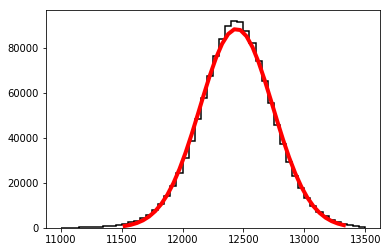

In [39]:
plot_fit_energy(fc)
print_fit_energy(fc)

In [40]:
kge = kr_event(dst, DT, E, E)

### Time dependence before/after correction

#### Before

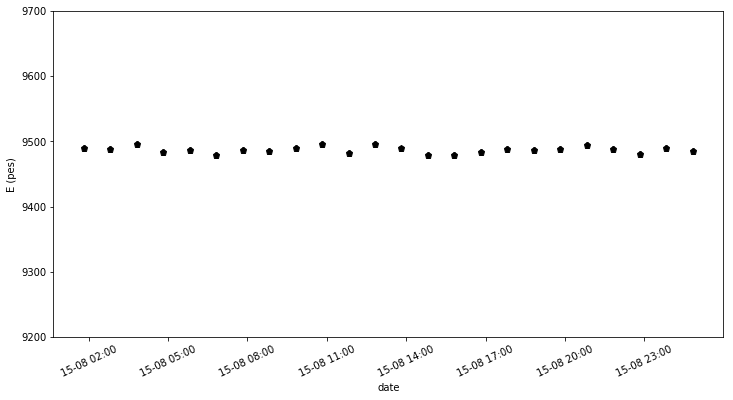

In [41]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9200, 9700),  
                    figsize=(12,6))

#### After

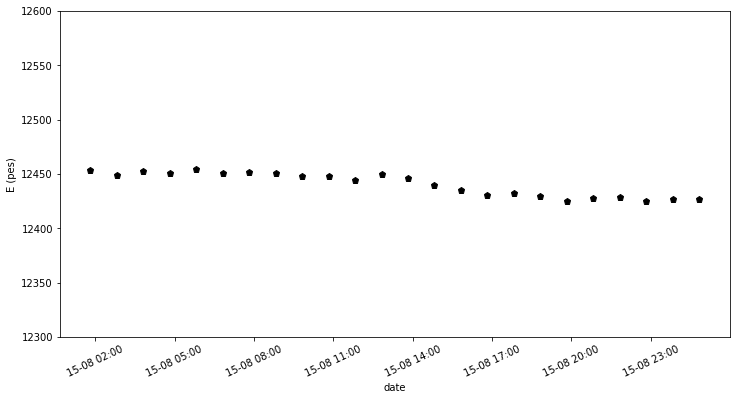

In [42]:
energy_time_profile(kge.T, kge.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12300, 12600),  
                    figsize=(12,6))

### Radial dependence

#### Before

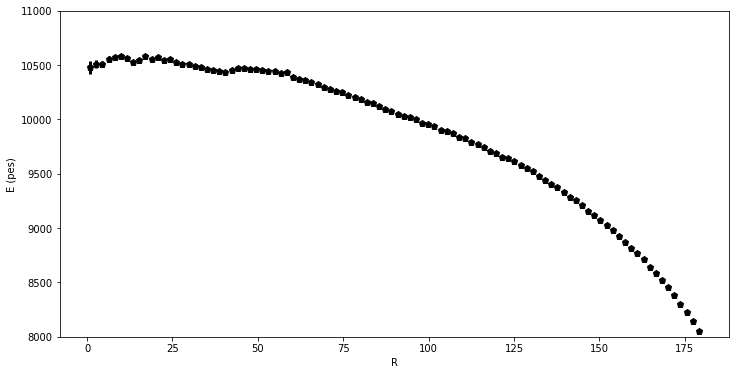

In [43]:
energy_X_profile(kge.R, kge.S2e, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

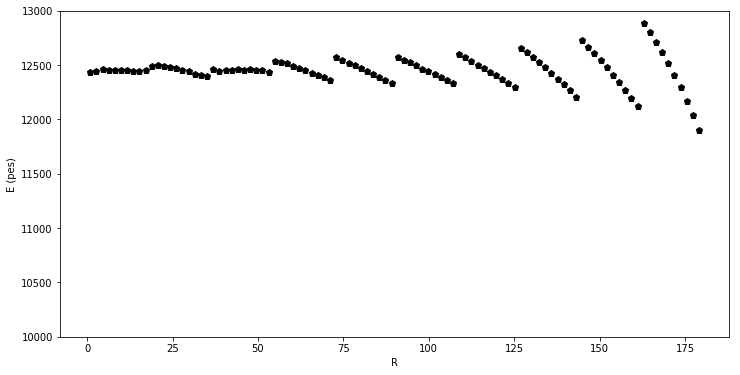

In [44]:
energy_X_profile(kge.R, kge.E, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 13000),  
                 figsize=(12,6))

### Phi distribution

#### Before

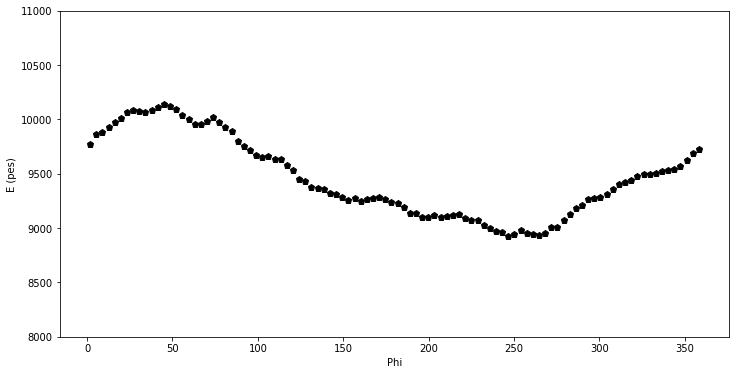

In [45]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

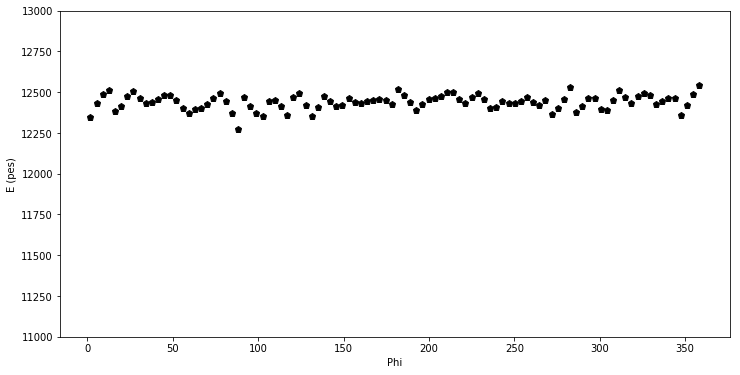

In [46]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13000),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

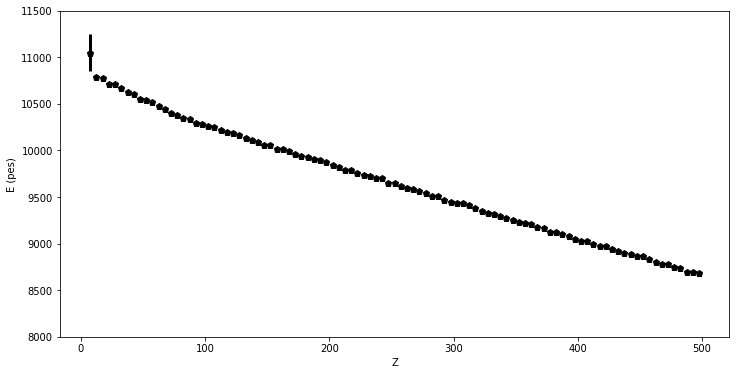

In [47]:
energy_X_profile(kge.Z, kge.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11500),  
                 figsize=(12,6))

#### After: Lifetime corrected

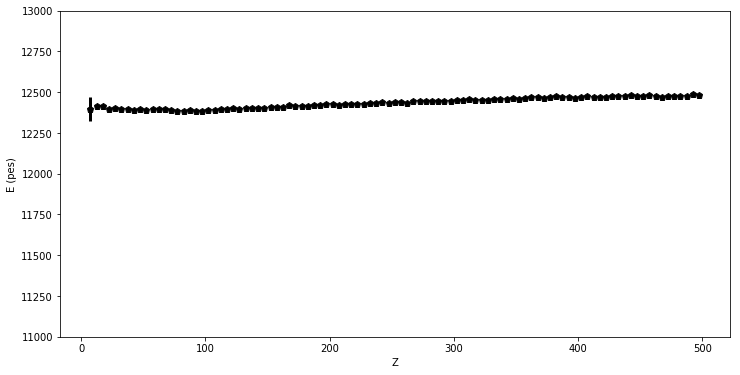

In [48]:
energy_X_profile(kge.Z, kge.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13000),   
                 figsize=(12,6))

## Further geometrical correction is needed. This is done reading a fine-grained map for energy

### Detail of the map granularity (to be loaded from file)

In [49]:
R, PHI = rphi_sector_map(nSectors=50, rmax=180, sphi=3)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [50]:
W = define_rphi_sectors(R, PHI, verbose=False)

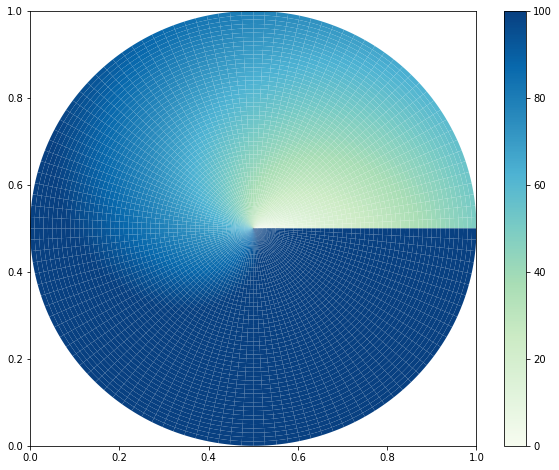

In [51]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(50))

In [52]:
eMap = read_energy_map(filename=fn.emap_file_name)

In [53]:
mx = (eMap.max()).max()
mx

13052.15806575247

In [54]:
mu = (eMap.mean()).mean()
mu

12412.469787445209

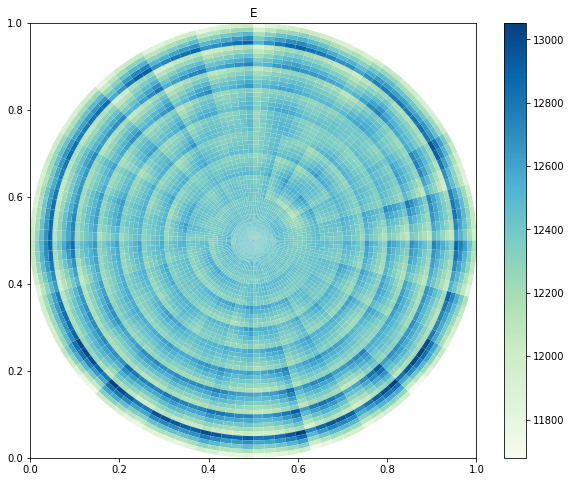

In [55]:
draw_energy_map_df(W, eMap, 
                elims  = None,
                cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                alpha   = 1.0,  
                figsize=(10,8))

In [56]:
ns = 50 # number of radial sectors used to compute map
nw = 120 # number of phi sectors used to compute map

fr = RMAX / ns
fphi = 360 / nw
print(f'fr = {fr}, fphi = {fphi}')

fr = 3.6, fphi = 3.0


In [57]:
t0 = time.time()
Ec = e0_correction(E, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = eMap / mu,  # normalize to mean
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 11.052359104156494


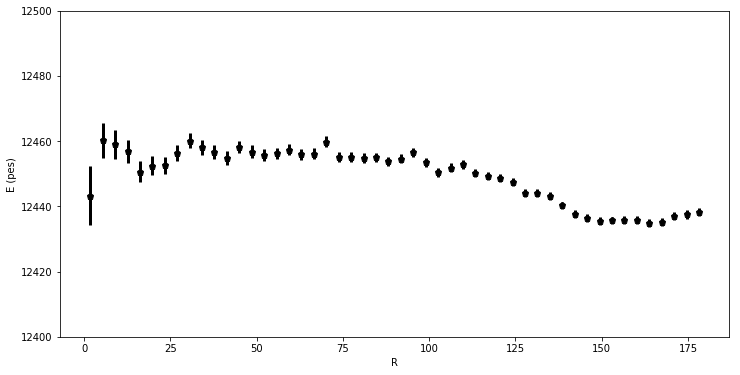

In [58]:
energy_X_profile(kge.R, Ec, xnbins = 50, xrange=(0,180), xlabel = 'R',
                 erange=(12400, 12500),  
                 figsize=(12,6))

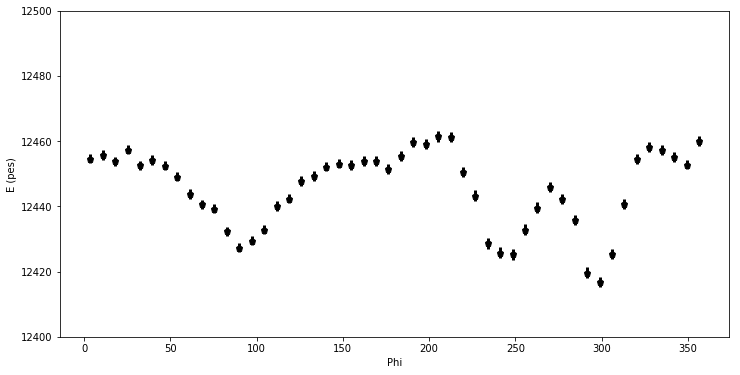

In [59]:
energy_X_profile(phirad_to_deg(kge.Phi), Ec, xnbins = 50, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(12400, 12500),  
                 figsize=(12,6))

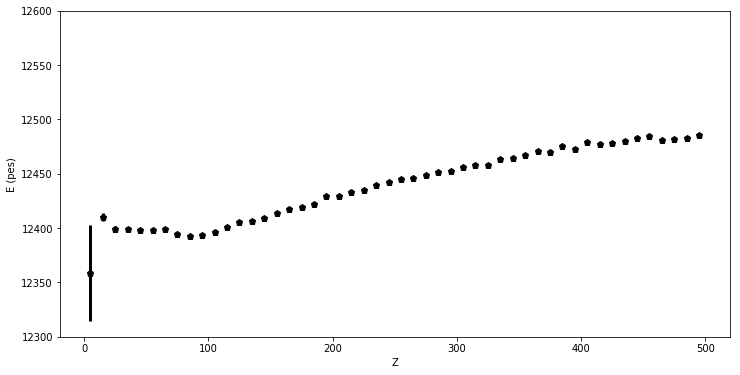

In [60]:
energy_X_profile(kge.Z, Ec, xnbins = 50, xrange=(0,500), xlabel = 'Z',
                 erange=(12300, 12600),   
                 figsize=(12,6))

### R and Phi distributions fixed, Z showing residual effects

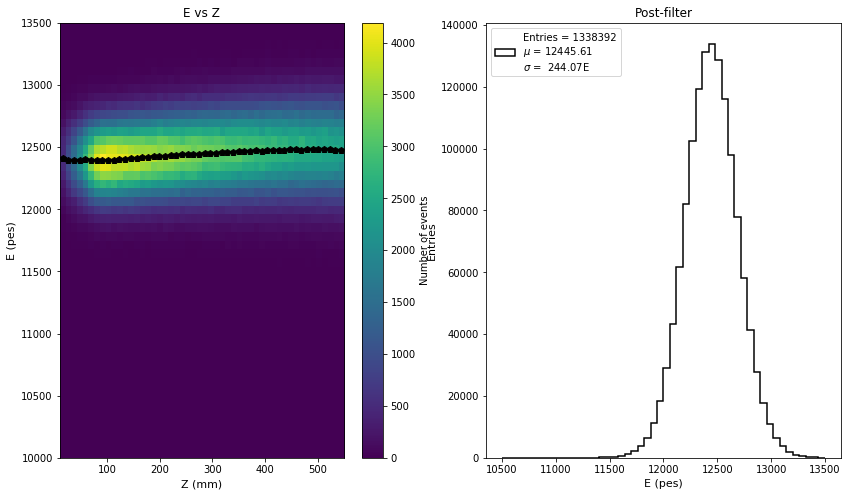

In [61]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, Ec, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12445.790904807094 +-0.211495932736973 
 E sigma   = 241.360073300531 +-0.16041252636869446 
 chi2    = 4.3356111346191435 
 sigma E/E (FWHM)     (%) =4.557333291186602
 sigma E/E (FWHM) Qbb (%) =0.5885885102687348 


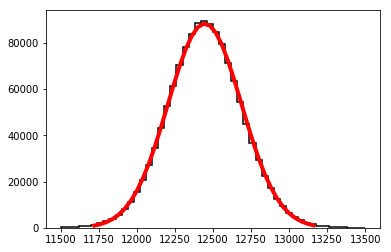

In [62]:
fc = fit_energy(Ec, nbins=50, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### Time correction

(12300, 12500)

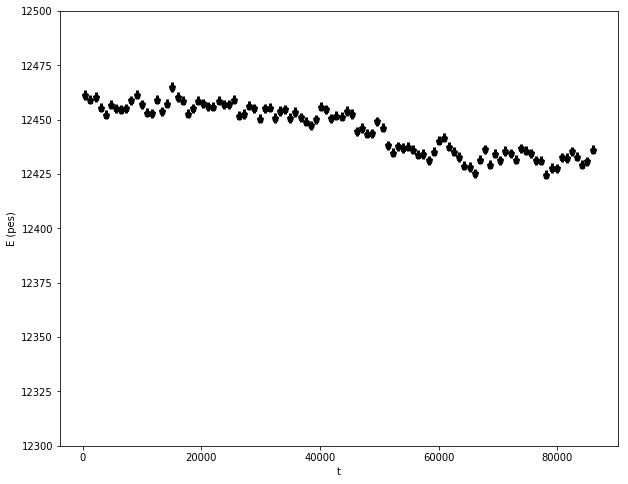

In [63]:
T   =(kge.T - kge.T.min()) 
t, e, eu = fitf.profileX(T, Ec, 100)
erange =(12300, 12500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [64]:
e_mu    = np.nanmean(Ec)
print(e_mu)
e_std   = np.nanstd (Ec)
print(e_std)

12445.683997943841
244.24198871001482


In [65]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = Ec * ET_correction(T).value

(12300, 12500)

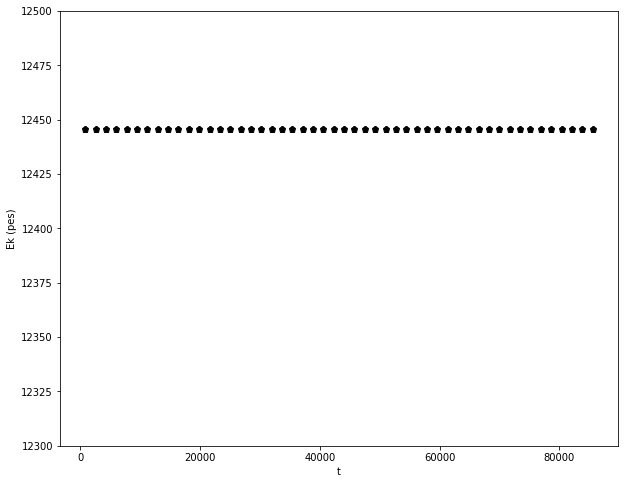

In [66]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

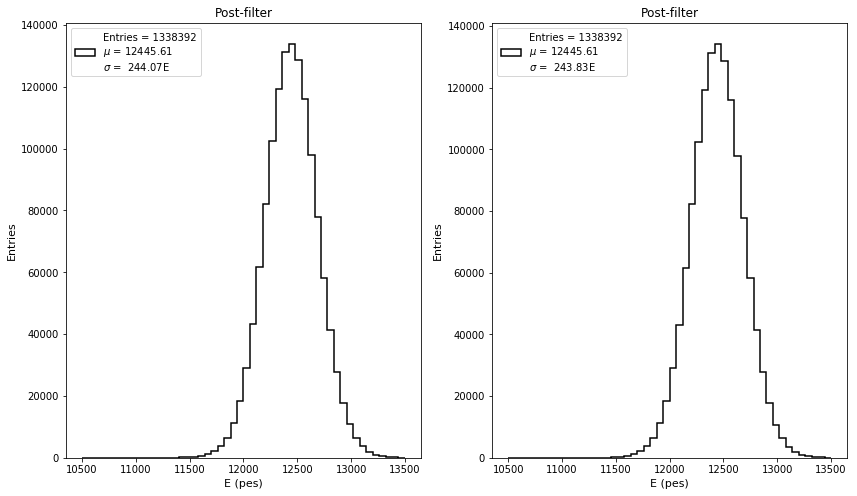

In [67]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(Ec,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 50, range =(10500,13500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12445.799771778482 +-0.21125849488934526 
 E sigma   = 241.11616320843592 +-0.16017079159079772 
 chi2    = 4.345176849139991 
 sigma E/E (FWHM)     (%) =4.552724565155486
 sigma E/E (FWHM) Qbb (%) =0.5879932842855624 


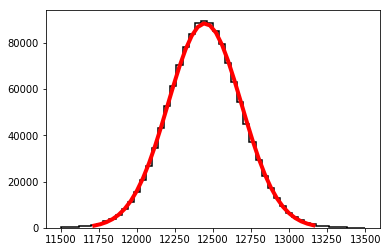

In [68]:
fc = fit_energy(Ek, nbins=50, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

In [69]:
Ri = (50,100,150,180)
Zi = range(50,600,50)

FWHM = resolution_r_z(Ri, Zi, kge.R, kge.Z, Ek)

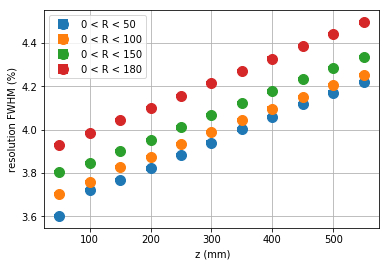

In [70]:
plot_resolution_r_z(Ri, Zi, FWHM)


### Is it possible to reduce the dependence in Z with time-dependent fits?